In [104]:
import xarray as xr 
import numpy as np
import math 
import glob
import s3fs 
import warnings 
import matplotlib.pyplot as plt

# NB!!! For alle dyp

In [2]:
def open_s3fs(path):
    # open the data with s3fs from the databucket 
    fsg = s3fs.S3FileSystem(anon=False,
      client_kwargs={
         'endpoint_url': 'https://karen.uiogeo-apps.sigma2.no'
      })
    data_path = f's3://data/{path}/*'
    remote_files = fsg.glob(data_path)
    fileset = [fsg.open(file) for file in remote_files]
    #open the dataset 
    dset = xr.open_mfdataset(fileset, combine='by_coords',compat='override')
    # rename variabel
    dset = dset.rename({'__xarray_dataarray_variable__' : 'vel'})
    return dset

In [3]:
ds = open_s3fs('PC-data')
ds

<xarray.Dataset>
Dimensions:        (depth: 75, x: 1580, y: 1801)
Coordinates:
  * depth          (depth) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
    time_centered  object ...
    time_counter   object ...
    nav_lat        (y, x) float32 dask.array<chunksize=(1801, 1580), meta=np.ndarray>
    nav_lon        (y, x) float32 dask.array<chunksize=(1801, 1580), meta=np.ndarray>
Dimensions without coordinates: x, y
Data variables:
    vel            (depth, y, x) float32 dask.array<chunksize=(75, 1801, 1580), meta=np.ndarray>
    mbathy         (y, x) int16 dask.array<chunksize=(1801, 1580), meta=np.ndarray>
    vomecrty       (depth, y, x) float32 dask.array<chunksize=(75, 1801, 1580), meta=np.ndarray>
    vozocrtx       (depth, y, x) float32 dask.array<chunksize=(75, 1801, 1580), meta=np.ndarray>

In [105]:
# open the data with s3fs from the databucket 
fsg = s3fs.S3FileSystem(anon=False,
      client_kwargs={
         'endpoint_url': 'https://karen.uiogeo-apps.sigma2.no'
      })
data_path = 's3://velocity-u.zarr/'
remote_files = fsg.glob(data_path)

store = s3fs.S3Map(root=data_path, s3=fsg, check=False)
du = xr.open_zarr(store=store, consolidated=True)
du = du.rename({'depthu' : 'depth'})


In [106]:
u = du.vozocrtx.isel(y=slice(900,1800), x=slice(200,1400))
mbathy = ds.mbathy.isel(y=slice(900,1800), x=slice(200,1400))

500 500
650 300
870 600
820 200
520 350


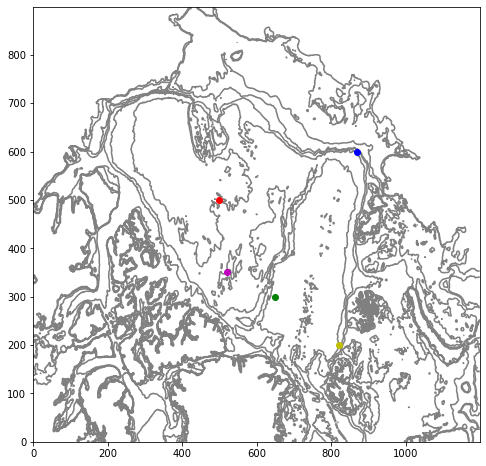

In [142]:
fig, axs = plt.subplots(1,1,figsize=(8,8))
c_list = ['r', 'g', 'b', 'y', 'm']
axs.contour(mbathy, colors = 'grey')

for p in range(len((punkt_list))):
    
    pp = punkt_list[p]
    print(pp[0], pp[1]) 
    axs.plot(pp[0],pp[1] ,marker = 'o' ,color = c_list[p])

In [125]:
pp = punkt_list[0]
pp[0]

500

## With surface currents 

In [102]:
def PCz(x,y):
    'Finding the level the given location dosent have values for anymore'

    d = mbathy.isel(x=x, y=y).values

    dyp = u.isel(x=x, y=y, depth = slice(0,d-1)) # -1 pga d=0 og vi vil en opp der vi har bunnhastigheter
    
    cov = np.cov(dyp.T, bias=True) # uten .T ble den en 73x73 matrise 
    values, vectors = np.linalg.eig(cov)
    order = values.argsort()[::-1]
    values, vectors = values[order], vectors[:, order]
    
    return  values, vectors, dyp

In [72]:
punkt_list = [(500,500), (650,300), (870,600), (820,200), (520,350)]

500 500
650 300
870 600
820 200
520 350


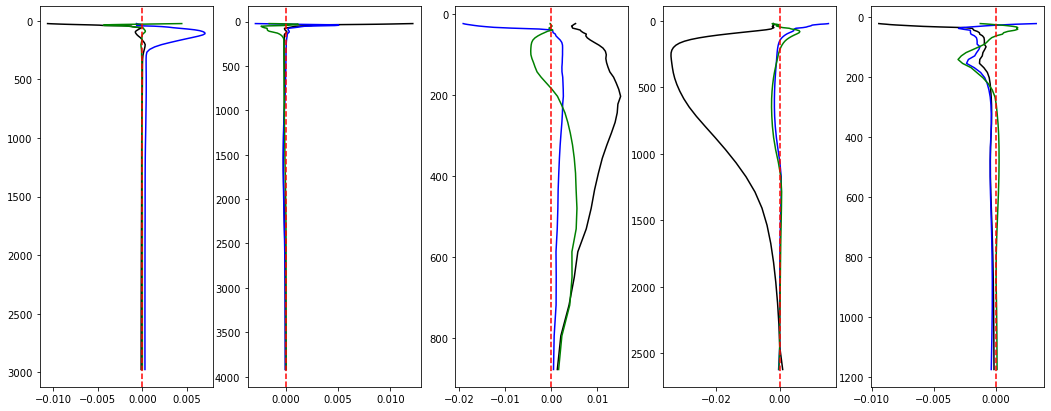

In [103]:
fig, axes = plt.subplots(1,5,figsize = (18,7))

for axs, p in zip(axes.flat, range(len((punkt_list)))):
    pp = punkt_list[p]
    print(pp[0], pp[1])    
    values, vectors, dyp = PCz(pp[0],pp[1])
        
    axs.plot(vectors[:,0]*np.sqrt(values[0]),dyp.depth+22, 'k')
    axs.plot(vectors[:,1]*np.sqrt(values[1]),dyp.depth+22, 'b')
    axs.plot(vectors[:,2]*np.sqrt(values[2]),dyp.depth+22, 'g')
    axs.axvline(0, color='r', linestyle = '--')
    axs.invert_yaxis()

## Skipping the 10 first m 

In [143]:
def PCz_10(x,y):
    'Finding the level the given location dosent have values for anymore'

    d = mbathy.isel(x=x, y=y).values

    dyp = u.isel(x=x, y=y, depth = slice(8,d-1)) # -1 pga d=0 og vi vil en opp der vi har bunnhastigheter
    
    cov = np.cov(dyp.T, bias=True) # uten .T ble den en 73x73 matrise 
    values, vectors = np.linalg.eig(cov)
    order = values.argsort()[::-1]
    values, vectors = values[order], vectors[:, order]
    
    return  values, vectors, dyp

500 500
650 300
870 600
820 200
520 350


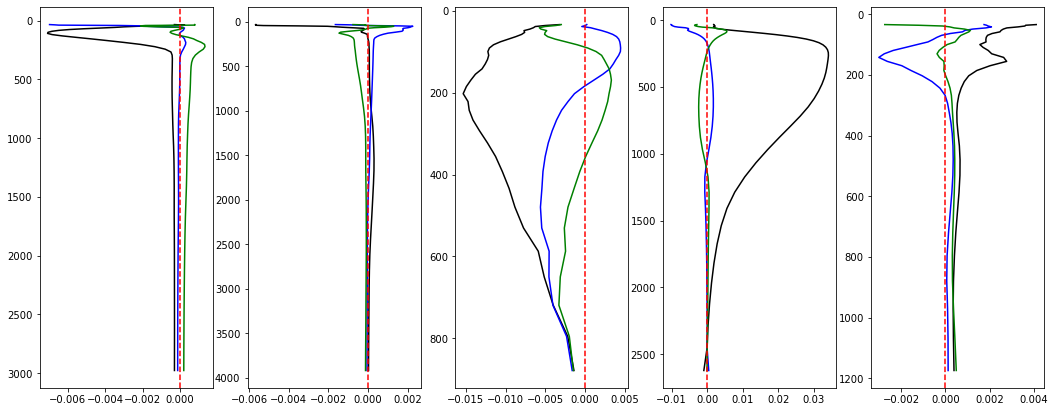

In [144]:
fig, axes = plt.subplots(1,5,figsize = (18,7))

for axs, p in zip(axes.flat, range(len((punkt_list)))):
    pp = punkt_list[p]
    print(pp[0], pp[1])    
    values, vectors, dyp = PCz_10(pp[0],pp[1])
        
    axs.plot(vectors[:,0]*np.sqrt(values[0]),dyp.depth+22, 'k')
    axs.plot(vectors[:,1]*np.sqrt(values[1]),dyp.depth+22, 'b')
    axs.plot(vectors[:,2]*np.sqrt(values[2]),dyp.depth+22, 'g')
    axs.axvline(0, color='r', linestyle = '--')
    axs.invert_yaxis()


## Skipping for first 20m

In [ ]:
def PCz_20(x,y):
    'Finding the level the given location dosent have values for anymore'

    d = mbathy.isel(x=x, y=y).values

    dyp = u.isel(x=x, y=y, depth = slice(15,d-1)) # -1 pga d=0 og vi vil en opp der vi har bunnhastigheter
    
    cov = np.cov(dyp.T, bias=True) # uten .T ble den en 73x73 matrise 
    values, vectors = np.linalg.eig(cov)
    order = values.argsort()[::-1]
    values, vectors = values[order], vectors[:, order]
    
    return  values, vectors, dyp

500 500
650 300
870 600
820 200
520 350


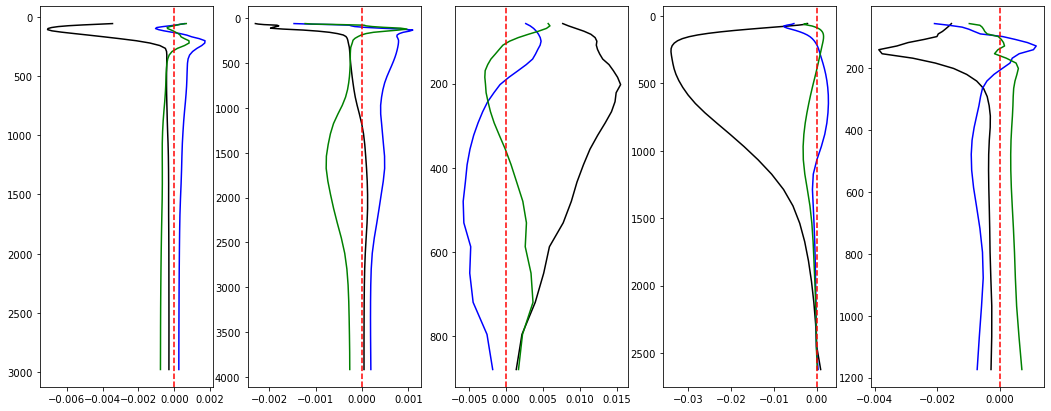

In [99]:
fig, axes = plt.subplots(1,5,figsize = (18,7))

for axs, p in zip(axes.flat, range(len((punkt_list)))):
    pp = punkt_list[p]
    print(pp[0], pp[1])    
    values, vectors, dyp = PCz_20(pp[0],pp[1])
        
    axs.plot(vectors[:,0]*np.sqrt(values[0]),dyp.depth+22, 'k')
    axs.plot(vectors[:,1]*np.sqrt(values[1]),dyp.depth+22, 'b')
    axs.plot(vectors[:,2]*np.sqrt(values[2]),dyp.depth+22, 'g')
    axs.axvline(0, color='r', linestyle = '--')
    axs.invert_yaxis()


## Skipping the first 41m 

In [100]:
def PCz_19(x,y):
    'Finding the level the given location dosent have values for anymore'

    d = mbathy.isel(x=x, y=y).values

    dyp = u.isel(x=x, y=y, depth = slice(19,d-1)) # -1 pga d=0 og vi vil en opp der vi har bunnhastigheter
    
    cov = np.cov(dyp.T, bias=True) # uten .T ble den en 73x73 matrise 
    values, vectors = np.linalg.eig(cov)
    order = values.argsort()[::-1]
    values, vectors = values[order], vectors[:, order]
    
    return  values, vectors, dyp

500 500
650 300
870 600
820 200
520 350


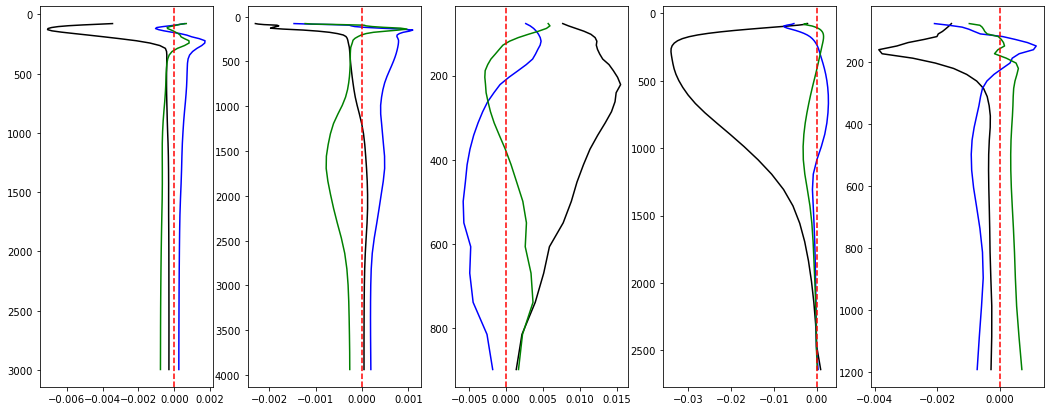

In [101]:
fig, axes = plt.subplots(1,5,figsize = (18,7))

for axs, p in zip(axes.flat, range(len((punkt_list)))):
    pp = punkt_list[p]
    print(pp[0], pp[1])    
    values, vectors, dyp = PCz(pp[0],pp[1])
        
    axs.plot(vectors[:,0]*np.sqrt(values[0]),dyp.depth+41, 'k')
    axs.plot(vectors[:,1]*np.sqrt(values[1]),dyp.depth+41, 'b')
    axs.plot(vectors[:,2]*np.sqrt(values[2]),dyp.depth+41, 'g')
    axs.axvline(0, color='r', linestyle = '--')
    axs.invert_yaxis()
